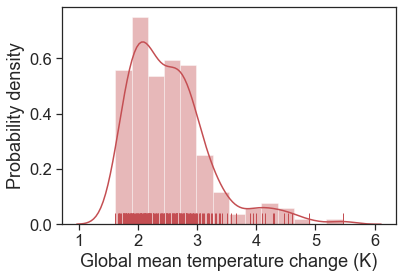

In [1]:
##Read BULK output from MAGICC6 and plot the distribution of 190 ensemble simulations
%matplotlib inline

rundir = '.\\'
runname = 'MAGICC6_GECO2019_zeroCO22050_OckoCH4_updatedBAURET2'
varname = '11_MAXTEMP2100'

##Read binary data, binData[4] is an integer shows number of simulations. There seems to be nothing in the header.
fbin = open(rundir + runname + '\\OUTPUT\\BULKOUT_'+ varname +'.BULKBINOUT', 'rb')
binData = fbin.read()
#print(binData[24:])
header = binData[0:3]
#n = binData[4] 

##Read the rest of bytes as double, in between numbers there are some empty bytes that I don't know what they are. Enable print to see details.
import struct
s=16
o = 8
n = len(binData[:])
numbers = ()
for i in range(s,n,16):
    numbers += struct.unpack('d',binData[i:(i+8)])
#    print(i,"to",i+8,"is",binData[i:(i+8)],"interpreted as",struct.unpack('d',binData[i:(i+8)]),"skipped:",i+9,"to",i+16,"is",binData[(i+9):(i+16)])
#print(numbers)
#print(len(numbers))

import seaborn as sns
import matplotlib.pyplot as plt
sns.set(context='notebook', style='ticks', palette='deep', font='sans-serif', font_scale=1.5, color_codes=True, rc=None)

g1 = sns.distplot(numbers, rug=True, kde=True, hist=True, color='r')
g1.set(xlabel='Global mean temperature change (K)',ylabel='Probability density')
plt.show()
fbin.close()

In [2]:
import scipy.stats
import numpy as np

confidence=0.95
a = 1.0 * np.array(numbers)
n = len(a)
m, se = np.mean(a), scipy.stats.sem(a)
h = se * scipy.stats.t.ppf((1 + confidence) / 2., n-1)
m, m-h, m+h


(2.5369814983016483, 2.4404074410380443, 2.6335555555652523)

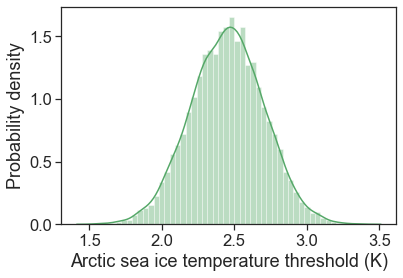

In [3]:
##Expand the number of samples by repeating the 190 simulations, preferably over 10,000.
while True:
    if (len(numbers)>10000):
        break
    numbers += numbers
#print(len(numbers))

##Generate the same number of sample in a lognormal distribution (use other type of distribution as needed).
import numpy as np
#mu, sigma, N = np.log(1.9), .38, int(len(numbers))
#grn_th = np.random.lognormal(mu, sigma, N)
mu, sigma, N = 2.45, .25, int(len(numbers))
grn_th = np.random.normal(mu, sigma, N)

g2 = sns.distplot(grn_th, kde=True, hist=True, color='g')
g2.set(xlabel='Arctic sea ice temperature threshold (K)',ylabel='Probability density')
plt.show()
fbin.close()

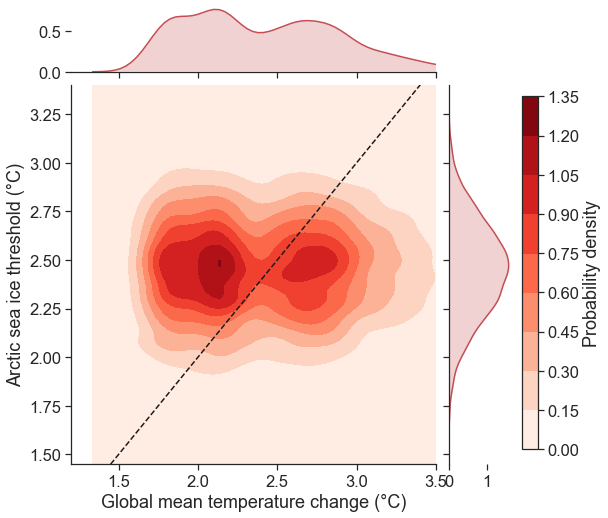

In [4]:
##Plot joint PDF using seaborn.
xmin = min(numbers)
xmax = max(numbers)
ymin = min(grn_th)
ymax = max(grn_th)

##Get the object JointGrid
#g3 = sns.JointGrid(numbers, grn_th, height=7, space=0.2, xlim=(xmin-0.2,xmax), ylim=(ymin,ymax))
g3 = sns.JointGrid(numbers, grn_th, height=7, space=0.2, xlim=(1.2,3.5), ylim=(1.45,3.4))
cbar_ax = g3.fig.add_axes([1, 0.1, .03, .7])  #define new axis to plot the colorbar
g3 = g3.plot_joint(sns.kdeplot, cmap="Reds", shade=True, cbar=True, cbar_ax=cbar_ax, cbar_kws={"label": 'Probability density'})
g3.set_axis_labels('Global mean temperature change ('+chr(176)+'C)','Arctic sea ice threshold ('+chr(176)+'C)',fontsize=18)

##customize axis tickmarks of the marginal histograms
g3.ax_marg_x.cla()
g3.ax_marg_y.cla()
for xlabel_i in g3.ax_marg_x.get_xticklabels():
        xlabel_i.set_visible(False)
for ylabel_i in g3.ax_marg_y.get_yticklabels():
        ylabel_i.set_visible(False)
#g3.ax_marg_x.yaxis.set_ticks([0.,0.5,1.])
#g3.ax_marg_y.xaxis.set_ticks([0.,0.3,.6])
g3 = g3.plot_marginals(sns.kdeplot, color="r", shade=True)

##Add a line onto the joint PDF
x0, x1 = g3.ax_joint.get_xlim()
y0, y1 = g3.ax_joint.get_ylim()
lims = [max(x0, y0), min(x1, y1)]
g3.ax_joint.plot(lims, lims, 'k--')
plt.show()

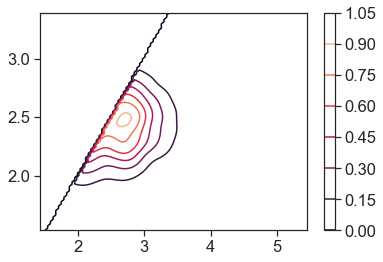

0.4919233201342214

In [5]:
##This part is used to integrate the joint PDF under the added line above (if x>y in this case). Plot the kde to double check.
data_2d = np.zeros((2,12160))
data_2d[0,:] = numbers
data_2d[1,:] = grn_th
xmin = data_2d[0,:].min()-0.2
xmax = data_2d[0,:].max()
ymin = data_2d[1,:].min()
ymax = data_2d[1,:].max()

from scipy import stats
X, Y = np.mgrid[xmin:xmax:100j, ymin:ymax:100j]  #define meshgrid X, Y are both 100x100
positions = np.vstack([X.ravel(), Y.ravel()])    #layout X,Y into positions to fit shape of the kernel which is 2x10000
kernel = stats.gaussian_kde(data_2d)
Z = np.reshape(kernel(positions).T, X.shape)     #reshape values in kernel to 100x100 for plotting
Z_tot = sum(sum(Z))                              #calculate the total power density to later use as denominator
for i in range(0,100):                           #where x<y, set the Z value to 0
    for j in range(0,100):
        if (X[i,j] < Y[i,j]):
            Z[i, j] = 0.
cset = plt.contour(X[:,0],Y[0,::-1],np.rot90(Z)) #plot to confirm zero line is drawn correctly
#plt.clabel(cset, inline=1, fontsize=10)
plt.colorbar()
plt.show()
sum(sum(Z))/Z_tot                                #integrated probability of the nonzero part